<IPython.core.display.Javascript object>


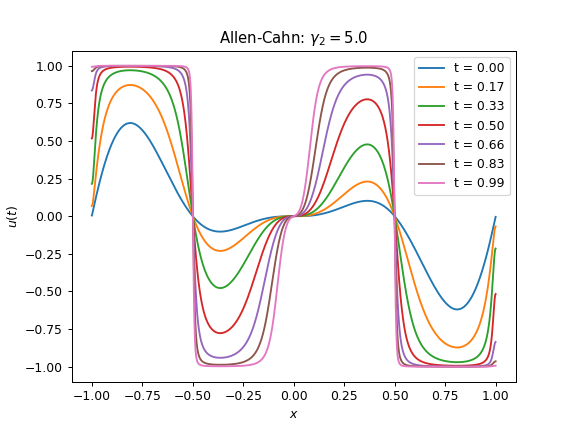

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [55]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# parameters
#####################################
nx       = 1000        # mesh points
theta    = 0.5         # time discretization
dt       = 5.0e-3      # time step
(x0, xf) = (-1.0, 1.0) # boundaries
order    = 2           # mesh polynomial order

# Class for interfacing with the Newton solver
class AllenCahnEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)
        
# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[0] < DOLFIN_EPS and x[0] > -DOLFIN_EPS and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - (xf - x0)

# formulate problem
#####################################
# create periodic boundary condition
pbc = PeriodicBoundary()

# setup mesh
mesh = IntervalMesh(nx, x0, xf)
V = FunctionSpace(mesh, "CG", order, constrained_domain=pbc)

# define test & trial functions
du = TrialFunction(V)
v = TestFunction(V)

# define functions
u = Function(V)
u0 = Function(V)

# initial conditions
u_init = Expression("pow(x[0],2)*sin(2*pi*x[0])", degree=2)
u.interpolate(u_init)
u0.interpolate(u_init)

mu_mid = (1.0-theta)*u0 + theta*u
gamma1 = 0.0001
gamma2 = 5.0 # {1 (easiest):5 (hardest)}

F = u*v*dx - u0*v*dx +                    \
    dt*gamma1*dot(grad(u), grad(v))*dx +  \
    dt*gamma2*(u**3 - u)*v*dx

J = derivative(F, u, du)

problem = AllenCahnEquation(J, F)
solver = NewtonSolver()

# map mesh vertices to solution DOFs
#####################################
dof_coordinates = V.tabulate_dof_coordinates()

# get indicies of sorted result
dofs      = np.squeeze(dof_coordinates)
asc_order = np.argsort(dofs)

# time stepping
#####################################
(t, T) = (0.0, 1.0)

plt.figure
plt.title(f"Allen-Cahn: $\gamma_2={gamma2}$")
plt.ylabel("$u(t)$")
plt.xlabel("$x$")
labels = []

while t < T:
    
    # compute current solution
    solver.solve(problem, u.vector())
    
    # update previous solution
    u0.vector()[:] = u.vector()
    
    # plot 6 solution snapshots
    if round(t/dt) % round(T/dt/6) == 0:
        plt.plot(dofs[asc_order], u.vector()[asc_order])
        labels.append(f"t = {t/T:.2f}")
        
    # increment time
    t += dt
    n += 1
    
plt.legend(labels)
plt.show()